## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

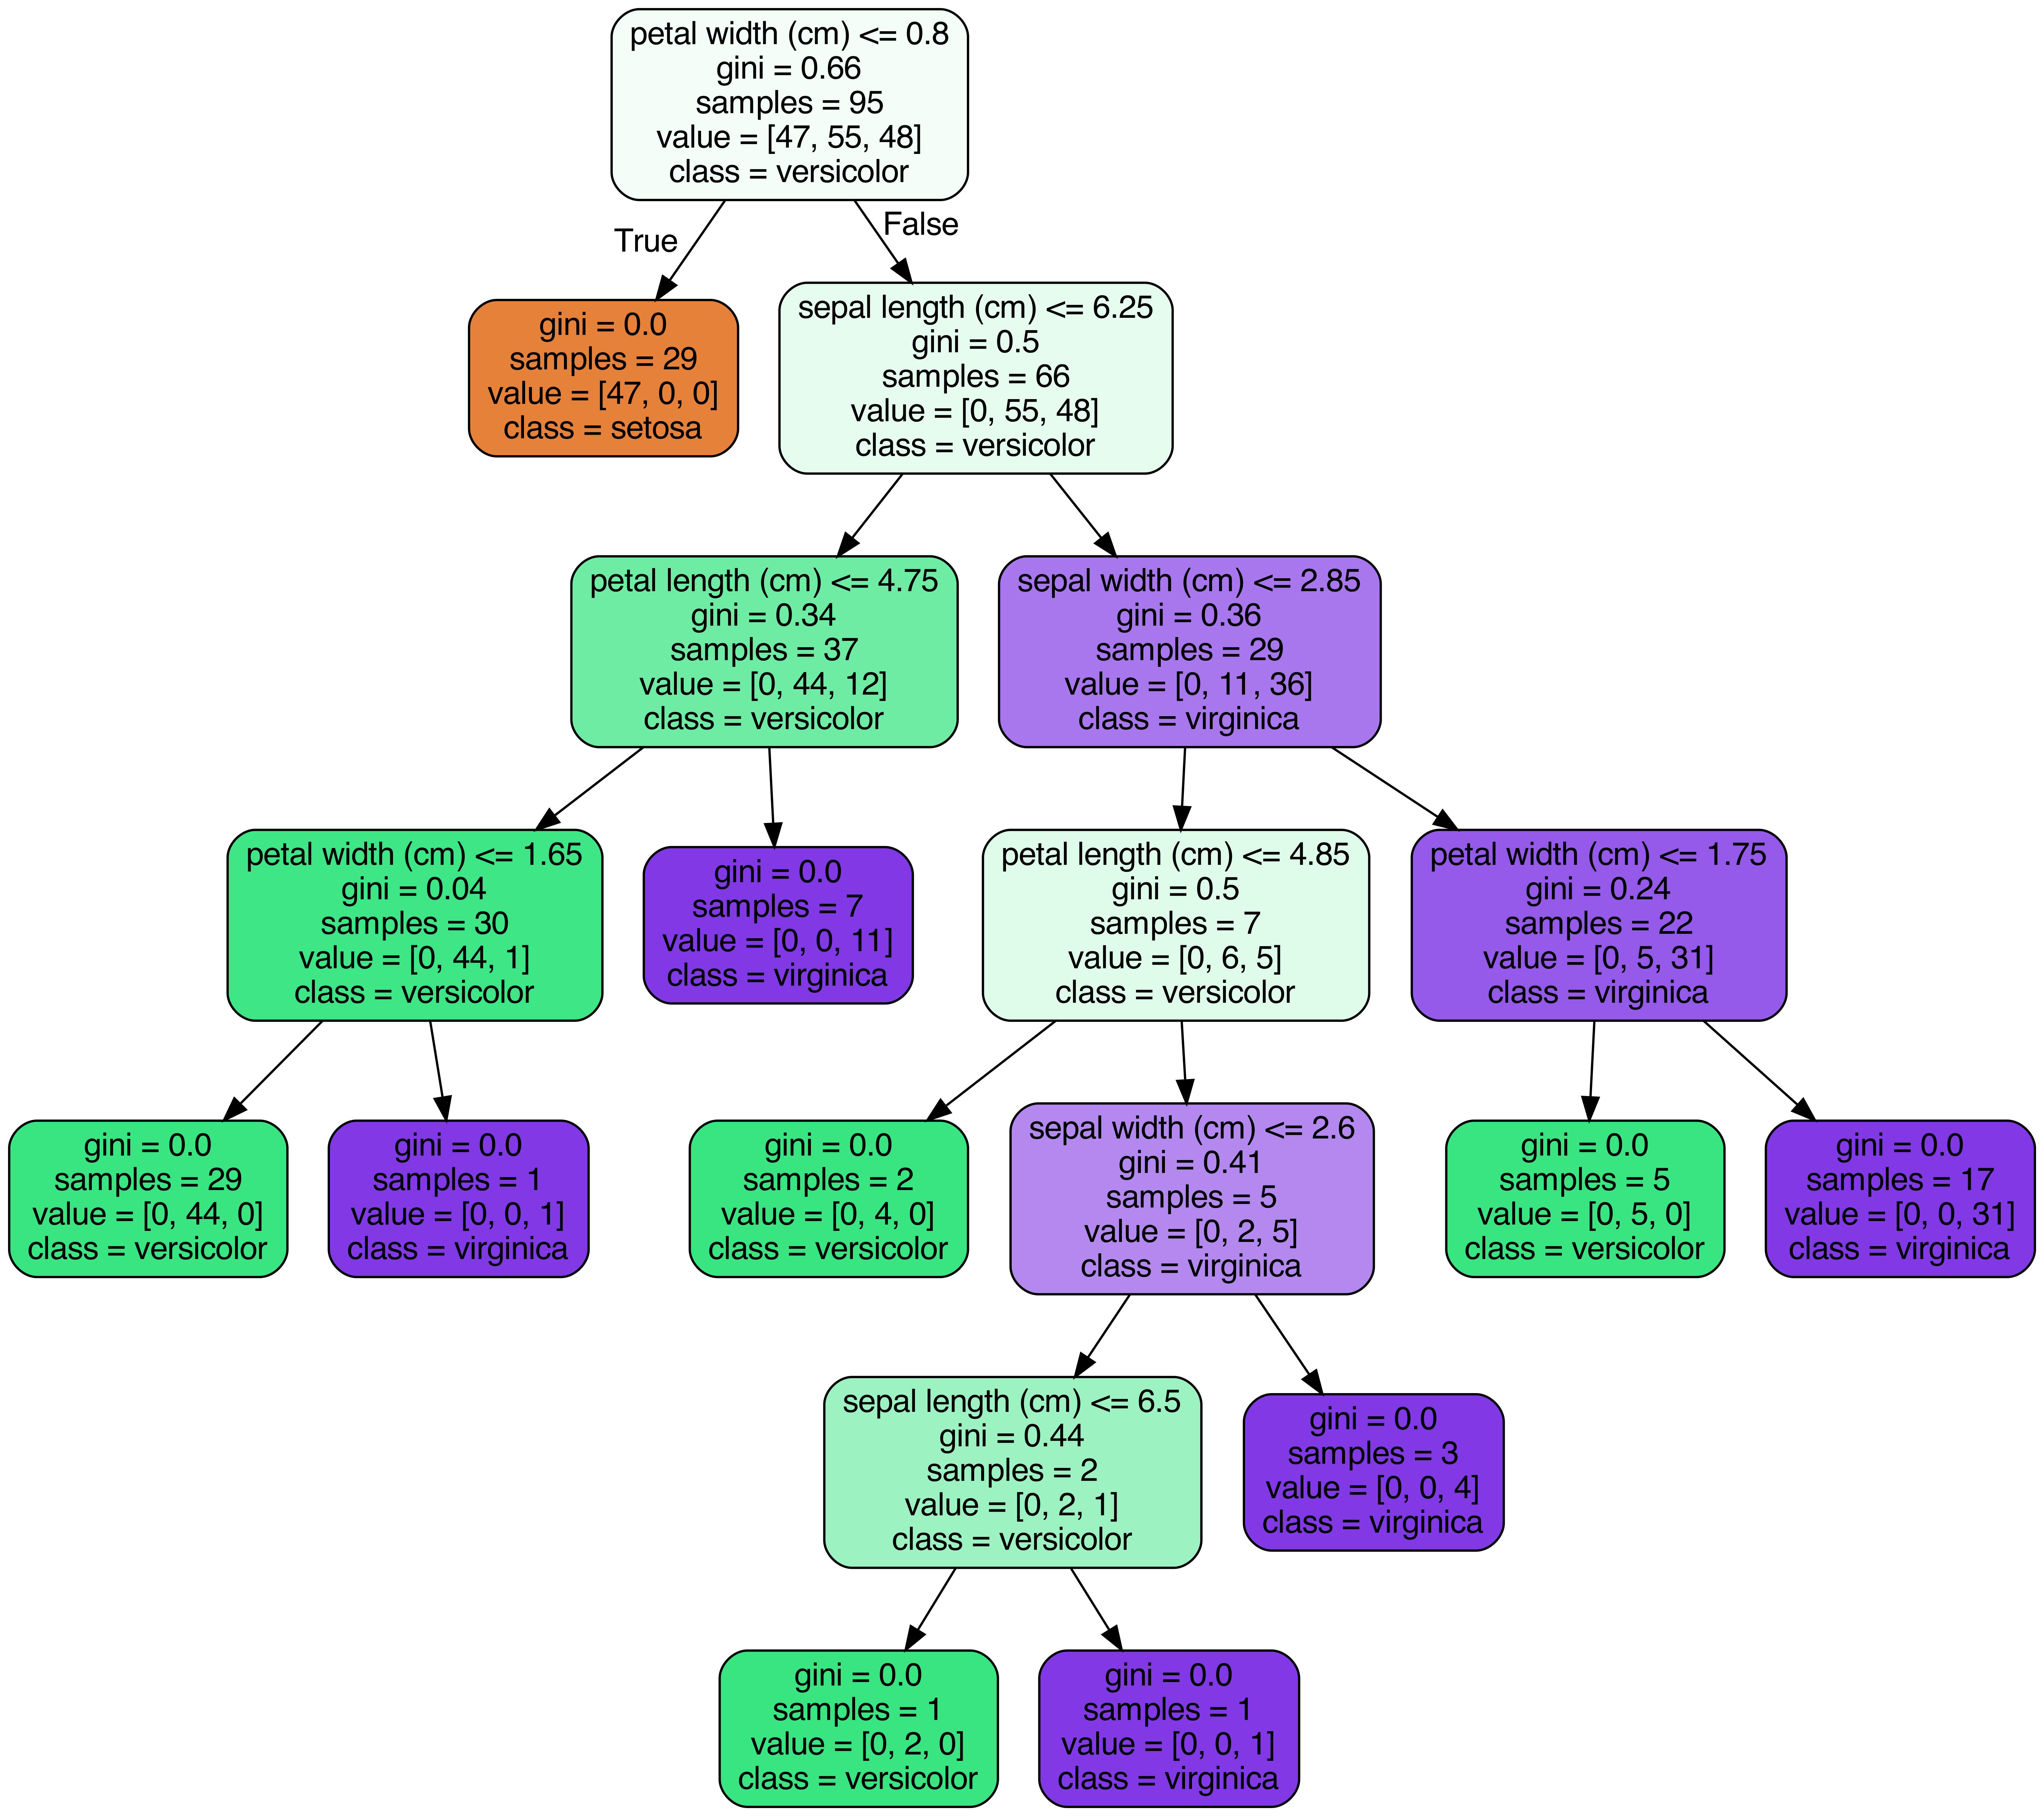

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df.state.value_counts()


isolated    1791
released     307
deceased      32
Name: state, dtype: int64

In [8]:
df.state.isnull().sum()
# 88 null values in the decision variable

88

In [9]:
datem = datetime.today().strftime("%Y")
datem = int(datem)

In [10]:
df['this_year'] = datem

In [11]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,this_year
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,2021
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,2021
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,2021
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,2021
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,2021


 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [12]:
df['n_age'] = df['this_year'] - df['birth_year']
df.drop(columns = ['this_year'], inplace = True)

In [13]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,57.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,34.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,57.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,30.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,29.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [14]:
df.shape

(2218, 19)

In [15]:
na_df = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
patient_id            2218 non-null int64
global_num            1314 non-null float64
sex                   2073 non-null object
birth_year            1764 non-null float64
age                   1957 non-null object
country               2218 non-null object
province              2218 non-null object
city                  2153 non-null object
disease               19 non-null object
infection_case        1163 non-null object
infection_order       42 non-null float64
infected_by           469 non-null float64
contact_number        411 non-null float64
symptom_onset_date    193 non-null object
confirmed_date        2077 non-null object
released_date         223 non-null object
deceased_date         32 non-null object
state                 2130 non-null object
n_age                 1764 non-null float64
dtypes: float64(6), int64(1), object(12)
memory usage: 329.4+ KB


 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [17]:
df["disease"] = df["disease"].replace(True,1)

In [18]:
df['disease'] = df['disease'].fillna(0)

In [19]:
df.disease.unique()

array([0., 1.])

In [20]:
df_missing = df[df['global_num'].isnull()]

In [21]:
df_missing.shape

(904, 19)

In [22]:
df_missing[df['contact_number'].isnull()].head()

/Users/ozgunuzer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
217,1000000218,NaN,male,1974.0,40s,Korea,Seoul,Guro-gu,0.0,Guro-gu Call Center,NaN,NaN,NaN,2020-03-10,2020-03-11,NaN,NaN,isolated,47.0
374,1100000093,NaN,male,1977.0,40s,Korea,Busan,etc,0.0,contact with patient,NaN,NaN,NaN,NaN,2020-03-11,NaN,NaN,isolated,44.0
375,1100000094,NaN,male,1972.0,40s,Korea,Busan,etc,0.0,contact with patient,NaN,NaN,NaN,2020-03-02,2020-03-12,NaN,NaN,isolated,49.0
376,1100000095,NaN,female,1932.0,80s,Korea,Busan,etc,0.0,NaN,NaN,NaN,NaN,2020-02-15,2020-03-13,NaN,NaN,isolated,89.0
377,1100000096,NaN,female,1971.0,40s,Korea,Busan,Haeundae-gu,0.0,contact with patient,NaN,NaN,NaN,2020-03-12,2020-03-13,NaN,NaN,isolated,50.0


In [23]:
df[df['patient_id'] == 1100000096]
# We look at one row with missing values for infection order, infected by , global_num, contact number, released date
# and deceased date

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
377,1100000096,NaN,female,1971.0,40s,Korea,Busan,Haeundae-gu,0.0,contact with patient,NaN,NaN,NaN,2020-03-12,2020-03-13,NaN,NaN,isolated,50.0


In [24]:
df.describe()

,patient_id,global_num,birth_year,disease,infection_order,infected_by,contact_number,n_age
count,2.218000e+03,1314.000000,1764.000000,2218.000000,42.000000,4.690000e+02,411.000000,1764.000000
mean,4.014678e+09,4664.816591,1974.988662,0.008566,2.285714,2.600789e+09,24.128954,46.011338
std,2.192419e+09,2874.044464,19.412643,0.092178,1.254955,1.570638e+09,91.087792,19.412643
min,1.000000e+09,1.000000,1916.000000,0.000000,1.000000,1.000000e+09,0.000000,1.000000
25%,1.700000e+09,1908.500000,1962.000000,0.000000,1.250000,1.200000e+09,2.000000,28.000000
50%,6.001000e+09,5210.500000,1974.500000,0.000000,2.000000,2.000000e+09,5.000000,46.500000
75%,6.004000e+09,7481.500000,1993.000000,0.000000,3.000000,4.100000e+09,16.000000,59.000000
max,7.000000e+09,8717.000000,2020.000000,1.000000,6.000000,6.113000e+09,1160.000000,105.000000


 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [25]:
df.global_num.dtype

dtype('float64')

In [26]:
round(df.global_num.mean())

4665

In [27]:
round(df.birth_year.mean())

1975

In [28]:
round(df.infection_order.mean(),1)

2.3

In [29]:
columns = ['global_num','birth_year','infection_order','infected_by','contact_number']
for column in columns:
    if column in ['global_num','birth_year',]:
        mean_val = round(df[column].mean())
    else:
        mean_val = round(df[column].mean(),1)
    print(column,mean_val)
    df[column] = df[column].fillna(mean_val)

global_num 4665
birth_year 1975
infection_order 2.3
infected_by 2600788987.6
contact_number 24.1


In [30]:
df[df['patient_id'] == 1100000096]
# We can see that the columns above are filled with the means

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
377,1100000096,4665.0,female,1971.0,40s,Korea,Busan,Haeundae-gu,0.0,contact with patient,2.3,2.600789e+09,24.1,2020-03-12,2020-03-13,NaN,NaN,isolated,50.0


 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [31]:
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,deceased_date,2186
1,symptom_onset_date,2025
2,released_date,1995
3,infection_case,1055
4,n_age,454
5,age,261
6,sex,145
7,confirmed_date,141
8,state,88
9,city,65


In [32]:
df.deceased_date = df.deceased_date.fillna(0) # put 0 if there is no deceased date
df.symptom_onset_date = df.symptom_onset_date.fillna(0) # put 0 if there is no symptom_onset_date
df.released_date = df.released_date.fillna(0) # put 0 if there is no released_date

In [33]:
df[df['patient_id'] == 1100000096]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
377,1100000096,4665.0,female,1971.0,40s,Korea,Busan,Haeundae-gu,0.0,contact with patient,2.3,2.600789e+09,24.1,2020-03-12,2020-03-13,0,0,isolated,50.0


In [34]:
df.infection_case.unique()

array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Pilgrimage to Israel'], dtype=object)

In [35]:
df[df.infection_case.isnull()]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
376,1100000095,4665.0,female,1932.0,80s,Korea,Busan,etc,0.0,NaN,2.3,2.600789e+09,24.1,2020-02-15,2020-03-13,0,0,isolated,89.0
378,1100000097,4665.0,male,1947.0,70s,Korea,Busan,Busanjin-gu,0.0,NaN,2.3,2.600789e+09,24.1,2020-03-09,2020-03-13,0,0,isolated,74.0
388,1200000038,38.0,female,1963.0,50s,Korea,Daegu,Nam-gu,1.0,NaN,2.3,2.600789e+09,24.1,0,2020-02-18,0,2020-02-23,deceased,58.0
392,1200000045,45.0,female,1966.0,50s,Korea,Daegu,Dalseong-gun,0.0,NaN,2.3,2.600789e+09,24.1,0,2020-02-19,0,0,isolated,55.0
393,1200000046,46.0,male,1992.0,20s,Korea,Daegu,Dalseo-gu,0.0,NaN,2.3,2.600789e+09,24.1,0,2020-02-19,0,0,isolated,29.0
399,1200000053,53.0,female,1982.0,30s,Korea,Daegu,NaN,0.0,NaN,2.3,2.600789e+09,24.1,0,2020-02-19,0,0,isolated,39.0
400,1200000057,57.0,male,1990.0,30s,Korea,Daegu,Jung-gu,0.0,NaN,2.3,2.600789e+09,24.1,0,2020-02-19,0,0,isolated,31.0
401,1200000058,58.0,female,1994.0,20s,Korea,Daegu,Nam-gu,0.0,NaN,2.3,2.600789e+09,24.1,0,2020-02-19,0,0,isolated,27.0
402,1200000059,59.0,female,1986.0,30s,Korea,Daegu,Nam-gu,0.0,NaN,2.3,2.600789e+09,24.1,0,2020-02-19,0,0,isolated,35.0
403,1200000060,60.0,female,1961.0,50s,Korea,Daegu,Nam-gu,0.0,NaN,2.3,2.600789e+09,24.1,0,2020-02-19,0,0,isolated,60.0


In [36]:
df[df['patient_id'] == 	6102000082]
# select one patient with infection case = 0

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
2210,6102000082,4665.0,male,1963.0,50s,Korea,Gyeongsangnam-do,Geochang-gun,0.0,NaN,2.3,2.600789e+09,24.1,0,2020-03-07,0,0,released,58.0


In [37]:
df.infection_case = df.infection_case.fillna('Unknown')
df.sex = df.sex.fillna('Unknown')

In [38]:
df.confirmed_date = df.confirmed_date.fillna(0)

In [39]:
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,n_age,454
1,age,261
2,state,88
3,city,65


In [40]:
df.sex.unique()

array(['male', 'female', 'Unknown'], dtype=object)

In [41]:
df[df['city'].isnull()]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
288,1100000007,4665.0,male,1994.0,20s,China,Busan,NaN,0.0,Shincheonji Church,2.3,2.600789e+09,485.0,0,2020-02-22,0,0,isolated,27.0
383,1200000031,31.0,female,1959.0,60s,Korea,Daegu,NaN,0.0,Shincheonji Church,2.3,2.600789e+09,1160.0,0,2020-02-18,0,0,isolated,62.0
394,1200000047,47.0,female,1957.0,60s,Korea,Daegu,NaN,0.0,Shincheonji Church,2.3,1.200000e+09,24.1,0,2020-02-19,0,0,isolated,64.0
395,1200000048,48.0,female,1948.0,70s,Korea,Daegu,NaN,0.0,Shincheonji Church,2.3,1.200000e+09,24.1,0,2020-02-19,0,0,isolated,73.0
396,1200000049,49.0,male,1962.0,50s,Korea,Daegu,NaN,0.0,Shincheonji Church,2.3,1.200000e+09,24.1,0,2020-02-19,0,0,isolated,59.0
397,1200000050,50.0,male,1944.0,70s,Korea,Daegu,NaN,0.0,Shincheonji Church,2.3,1.200000e+09,24.1,0,2020-02-19,2020-03-02,0,released,77.0
398,1200000051,51.0,female,1959.0,60s,Korea,Daegu,NaN,0.0,Shincheonji Church,2.3,1.200000e+09,24.1,0,2020-02-19,2020-02-26,0,released,62.0
399,1200000053,53.0,female,1982.0,30s,Korea,Daegu,NaN,0.0,Unknown,2.3,2.600789e+09,24.1,0,2020-02-19,0,0,isolated,39.0
406,1200000063,63.0,female,1968.0,50s,Korea,Daegu,NaN,0.0,Unknown,2.3,2.600789e+09,24.1,0,2020-02-19,2020-02-28,0,released,53.0
407,1200000064,64.0,female,1961.0,50s,Korea,Daegu,NaN,0.0,Unknown,2.3,2.600789e+09,24.1,0,2020-02-19,0,0,isolated,60.0


In [42]:
df['city'].value_counts()

Gyeongsan-si     535
Cheonan-si        98
Seongnam-si       89
Bonghwa-gun       60
Gumi-si           59
                ... 
Anseong-si         1
Gimje-si           1
Yeongyang-gun      1
Yeosu-si           1
Hamyang-gun        1
Name: city, Length: 134, dtype: int64

In [43]:
# Fill city values with forward fill
df['city'] = df['city'].fillna(method = 'ffill')

In [44]:
df.city.value_counts()

Gyeongsan-si       535
Cheonan-si          98
Seongnam-si         89
Bonghwa-gun         60
Gumi-si             59
                  ... 
Anseong-si           1
Jeungpyeong-gun      1
Namhae-gun           1
Dalseong-gun         1
Guri-si              1
Name: city, Length: 134, dtype: int64

 **<font color='teal'> Check for any remaining null values.</font>**

In [45]:
na_df = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,n_age,454
1,age,261
2,state,88


In [46]:
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

In [47]:
df.state.isnull().sum()

88

In [48]:
df.state = df.state.fillna('missing')

In [49]:
df.state.unique()

array(['released', 'isolated', 'deceased', 'missing'], dtype=object)

In [50]:
df['n_age'].dtype

dtype('float64')

In [51]:
df['age'].value_counts()

20s     467
50s     385
40s     303
30s     251
60s     229
70s     117
80s      84
10s      74
0s       29
90s      17
100s      1
Name: age, dtype: int64

In [52]:
df['n_age'] = df['n_age'].fillna(round(df['n_age'].mean()))
df['age'] = df['age'].fillna(method = 'ffill')
df['state'] = df['state'].fillna(method = 'ffill')


In [53]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0.0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,0,released,57.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0.0,overseas inflow,1.0,2.600789e+09,31.0,0,2020-01-30,2020-03-02,0,released,34.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0.0,contact with patient,2.0,2.002000e+09,17.0,0,2020-01-30,2020-02-19,0,released,57.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0.0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,0,released,30.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0.0,contact with patient,2.0,1.000000e+09,2.0,0,2020-01-31,2020-02-24,0,released,29.0


Remove date columns from the data.


In [54]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [55]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   3
birth_year           96
age                  11
country               4
province             17
city                134
disease               2
infection_case       17
infection_order       7
infected_by         207
contact_number       73
state                 4
n_age                96
dtype: int64


Review the percent of unique values by column.

In [56]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.001353
birth_year         0.043282
age                0.004959
country            0.001803
province           0.007665
city               0.060415
disease            0.000902
infection_case     0.007665
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001803
n_age              0.043282
dtype: float64


Review the range of values per column.

In [57]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664891e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.665000e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974991e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.975000e+03,1.988000e+03,2.020000e+03
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.299729e+00,1.706733e-01,1.000000e+00,2.300000e+00,2.300000e+00,2.300000e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.410537e+01,3.917142e+01,0.000000e+00,2.410000e+01,2.410000e+01,2.410000e+01,1.160000e+03
n_age,2218.0,4.600902e+01,1.731123e+01,1.000000e+00,3.300000e+01,4.600000e+01,5.600000e+01,1.050000e+02


### Check for duplicated rows

In [58]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF
# No duplicated rows

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [59]:
cat = df.select_dtypes(include=['object'], exclude=['datetime'])
cat.shape

(2218, 7)

In [60]:
cat.columns

Index(['sex', 'age', 'country', 'province', 'city', 'infection_case', 'state'], dtype='object')

In [61]:
#get levels for all variables
var = pd.DataFrame(cat.nunique()).reset_index()
var.columns = ['VarName', 'LevelsCount']
var.sort_values(by='LevelsCount', ascending =False)
var

,VarName,LevelsCount
0,sex,3
1,age,11
2,country,4
3,province,17
4,city,134
5,infection_case,17
6,state,4


**<font color='teal'> Plot the correlation heat map for the features.</font>**

<AxesSubplot:>

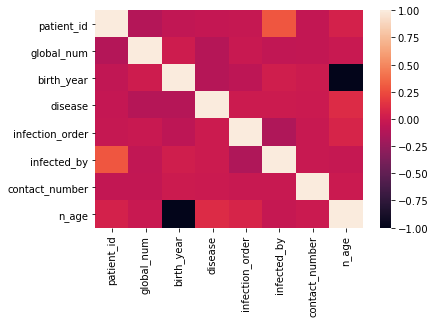

In [62]:
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

<AxesSubplot:>

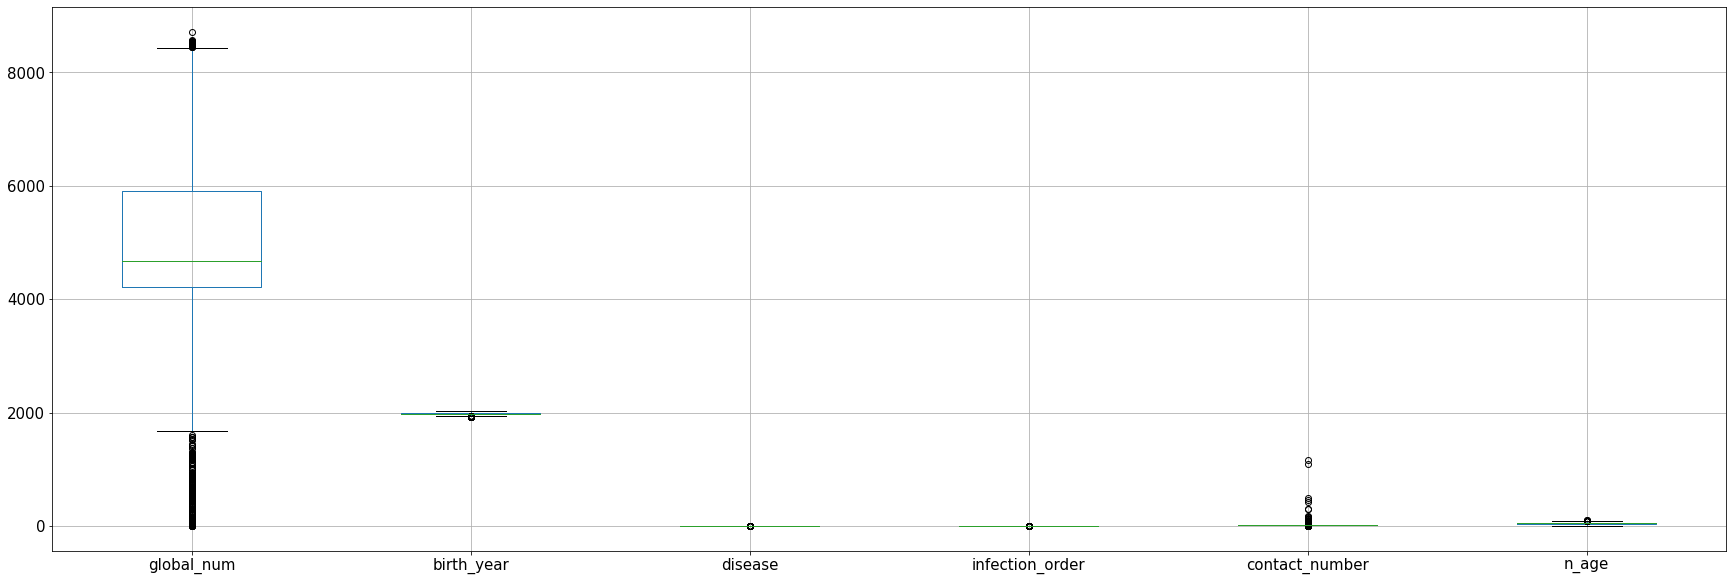

In [63]:
df1 = df.drop(['patient_id', 'infected_by'], axis=1)
df1.boxplot(fontsize=15, figsize=(30,10))

**<font color='teal'> Create dummy features for object type features. </font>**

In [64]:
y = df['state']

In [65]:
X = df.drop(columns = 'state')

In [66]:
X.dtypes

patient_id           int64
global_num         float64
sex                 object
birth_year         float64
age                 object
country             object
province            object
city                object
disease            float64
infection_case      object
infection_order    float64
infected_by        float64
contact_number     float64
n_age              float64
dtype: object

In [67]:
X = pd.get_dummies(X)


In [68]:
y.unique()

array(['released', 'isolated', 'deceased', 'missing'], dtype=object)

In [69]:
states = ['released', 'isolated', 'deceased','missing']
i = 1
for st in states:
    df['state'].replace(st, i, inplace=True)
    i += 1
y = df['state']
df['state'].unique()

array([1, 2, 3, 4])

### Split the data into test and train subsamples

In [70]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [71]:
#scale data
from sklearn import preprocessing
import numpy as np

# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [72]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [73]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.847
Random Forest: f1-score=0.812


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [74]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[ 12  57   0   0]
 [  8 343   0   0]
 [  0   1   6   0]
 [  0   2   0  15]]
Normalized confusion matrix
[[0.17 0.83 0.   0.  ]
 [0.02 0.98 0.   0.  ]
 [0.   0.14 0.86 0.  ]
 [0.   0.12 0.   0.88]]


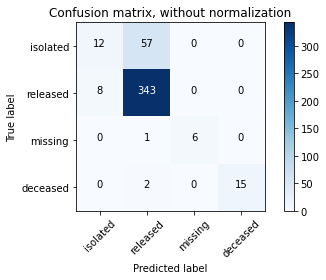

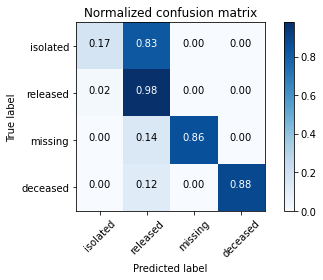

In [75]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


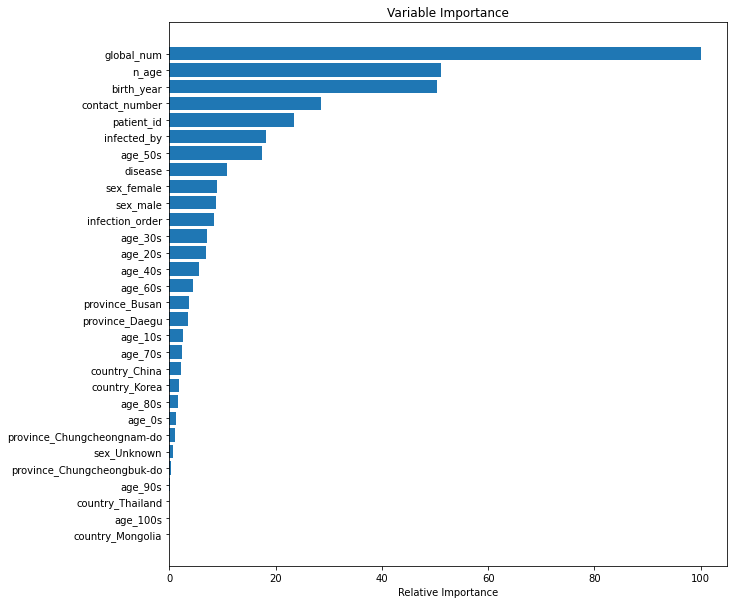

In [76]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.